In [1]:
%pip install -U langchain openai langchain-chroma langchain-experimental

  Using cached langchain-0.3.22-py3-none-any.whl.metadata (7.8 kB)
  Using cached openai-1.70.0-py3-none-any.whl.metadata (25 kB)
Using cached langchain-0.3.22-py3-none-any.whl (1.0 MB)
Using cached openai-1.70.0-py3-none-any.whl (599 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 21.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3
  Attempting uninstall: openai
    Found existing installation: openai 1.69.0
    Uninstalling openai-1.69.0:
      Successfully uninstalled openai-1.69.0
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.21
    Uninstalling langchain-0.3.21:
      Successfully uninstalled langchain-0.3.21
Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install "unstructured[all-docs]" pillow pydantic lxml pillow matplotlib chromadb tiktoken pdf2image

Note: you may need to restart the kernel to use updated packages.


In [59]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf


# Extract tables from PDF
def extract_tables_from_pdf(path, fname):
    """
    Extract tables from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=True,
        infer_table_structure=True,
    )

# Extract text from PDF with chunking
def extract_text_from_pdf(path, fname):
    """
    Extract and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
    )



def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
            print("text", str(element))
    return texts, tables


# File path
fpath = "../document/"
fname = "attention-is-all-you-need-Paper.pdf"

# First extract tables
table_elements = extract_tables_from_pdf(fpath, fname)
texts, tables = categorize_elements(table_elements)

# Then extract text with chunking
text_elements = extract_text_from_pdf(fpath, fname)
texts, _ = categorize_elements(text_elements)


CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, def

text Attention Is All You Need

Ashish Vaswani∗ Google Brain avaswani@google.com

Noam Shazeer∗ Google Brain noam@google.com

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗ Google Research usz@google.com

Llion Jones∗ Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin∗ ‡ illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring signiﬁcantly less time to t

In [61]:
# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [22]:
%pip install nest-asyncio

Note: you may need to restart the kernel to use updated packages.


In [62]:
import os
from dotenv import load_dotenv
from openai import OpenAI
load_dotenv()
import asyncio
import nest_asyncio
nest_asyncio.apply()
from concurrent.futures import ThreadPoolExecutor
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key = OPENAI_API_KEY)

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
# from langchain_openai import ChatOpenAI


async def summarize_element(element):
    """
    Summarize a single element using OpenAI API
    """
    response = client.chat.completions.create(
        model="gpt-4",
        temperature=0,
        messages=[
            {"role": "system", "content": "You are an assistant tasked with summarizing tables and text for retrieval."},
            {"role": "user", "content": f"You are an assistant tasked with summarizing tables and text for retrieval. These summaries will be embedded and used to retrieve the raw text or table elements. Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element}"}
        ]
    )
    return response.choices[0].message.content


async def process_batch(elements, max_concurrency=5):
    """
    Process a batch of elements with concurrency control
    """
    semaphore = asyncio.Semaphore(max_concurrency)
    
    async def process_with_semaphore(element):
        async with semaphore:
            return await summarize_element(element)
    
    tasks = [process_with_semaphore(element) for element in elements]
    return await asyncio.gather(*tasks)

# get text summaries
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """
    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Create event loop for async operations
    loop = asyncio.new_event_loop()
    asyncio.set_event_loop(loop)

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = loop.run_until_complete(process_batch(texts, max_concurrency=5))
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = loop.run_until_complete(process_batch(tables, max_concurrency=5))

    loop.close()
    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [63]:
table_summaries

['The table compares the complexity per layer, sequential maximum path length, and operations of different layer types: Self-Attention, Recurrent, Convolutional, and Restricted Self-Attention. Self-Attention has a complexity of O(n2 · d), path length of O(1), and operations of O(1). Recurrent has a complexity of O(n · d2), path length of O(n), and operations of O(n). Convolutional has a complexity of O(k · n · d2), path length of O(1), and operations of O(logk(n)). Restricted Self-Attention has a complexity of O(r · n · d), path length of O(1), and operations of O(n/r).',
 'The table presents the performance of various machine translation models, measured by BLEU scores for English to German (EN-DE) and English to French (EN-FR) translations, and their respective training costs in FLOPs. The models include ByteNet, Deep-Att + PosUnk, GNMT + RL, ConvS2S, MoE, and Transformer (base and big models). The highest BLEU scores for EN-DE and EN-FR are achieved by Deep-Att + PosUnk Ensemble and

In [64]:
text_summaries

['The paper "Attention Is All You Need" by Vaswani et al. proposes a new network architecture called the Transformer, which is based solely on attention mechanisms and does away with recurrence and convolutions entirely. The Transformer model has been found to be superior in quality, more parallelizable, and requires significantly less time to train compared to dominant sequence transduction models. The model achieved a BLEU score of 28.4 on the WMT 2014 English-to-German translation task and 41.0 on the English-to-French translation task. The Transformer uses multi-head attention in three different ways: encoder-decoder attention, self-attention layers in the encoder, and self-attention layers in the decoder. The model also includes position-wise feed-forward networks and positional encoding to make use of the order of the sequence.',
 'The text discusses the Transformer, a sequence transduction model based entirely on attention, which replaces recurrent layers in encoder-decoder arch

In [66]:
import base64
import os

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def image_summarize(img_base64, prompt):
    """Make image summary using OpenAI API directly"""
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        max_tokens=1024,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            }
        ]
    )
    return response.choices[0].message.content


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

fpath = "figures/"

# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [74]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
# from langchain_openai import OpenAIEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts using ChromaDB for local storage
    """
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag", embedding_function=embeddings,
    persist_directory="./chroma_db"
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [87]:
import io
import re
import base64
from IPython.display import HTML, display
from PIL import Image
from openai import OpenAI

def plt_img_base64(img_base64):
    """Display base64 encoded string as image"""
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    display(HTML(image_html))

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None

def is_image_data(b64data):
    """Check if the base64 data is an image by looking at the start of the data"""
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False

def resize_base64_image(base64_string, size=(128, 128)):
    """Resize an image encoded as a Base64 string"""
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))
    resized_img = img.resize(size, Image.LANCZOS)
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def split_image_text_types(docs):
    """Split base64-encoded images and texts"""
    b64_images = []
    texts = []
    for doc in docs:
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}

def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain using OpenAI API directly
    """
    def process_query(query):
        # Get relevant documents from retriever
        docs = retriever.get_relevant_documents(query)
        
        # Split into images and texts
        split_docs = split_image_text_types(docs)
        
        # Prepare messages for OpenAI API
        messages = []
        
        # Add system message
        messages.append({
            "role": "system",
            "content": """You are an AI assistant tasked with explaining the "Attention is All You Need" paper.
            This paper introduced the Transformer architecture, which revolutionized natural language processing.
            Your goal is to help users understand the key concepts, architecture, and innovations in this paper.
            Be precise, technical, and clear in your explanations."""
        })
        
        # Add images if present
        if split_docs["images"]:
            for image in split_docs["images"]:
                messages.append({
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": "Please analyze this figure from the 'Attention is All You Need' paper:"
                        },
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:image/jpeg;base64,{image}"}
                        }
                    ]
                })
        
        # Add the main query with context
        formatted_texts = "\n\n".join(split_docs["texts"])
        messages.append({
            "role": "user",
            "content": f"""Based on the following context from the 'Attention is All You Need' paper, please answer this question: {query}

Context:
{formatted_texts}

Please provide a detailed, technical explanation that helps understand the paper's concepts in relation to the question."""
        })
        
        # Call OpenAI API
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            max_tokens=1024,
            temperature=0
        )
        
        return response.choices[0].message.content
    
    return process_query

# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

# Example usage:
# result = chain_multimodal_rag("Explain the multi-head attention mechanism in the Transformer architecture.")


In [77]:
# Check retrieval
query = "Explain the multi-head attention mechanism in the Transformer architecture."
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

3

In [89]:
print(chain_multimodal_rag(query))

The multi-head attention mechanism is a core component of the Transformer architecture introduced in the "Attention is All You Need" paper. It enhances the model's ability to focus on different parts of the input sequence simultaneously, allowing for a richer representation of the data. Here’s a detailed breakdown of how it works:

### 1. **Attention Mechanism Basics**
At its core, the attention mechanism computes a weighted sum of values (V) based on the relevance of queries (Q) to keys (K). The attention score is calculated using the dot product of the query and key vectors, followed by a softmax operation to obtain the attention weights.

### 2. **Scaled Dot-Product Attention**
The basic attention mechanism used in the Transformer is called scaled dot-product attention. It is defined as follows:
- **Input**: Queries (Q), Keys (K), and Values (V).
- **Computation**:
  \[
  \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
  \]
  Here, \(d_k\) is the dime


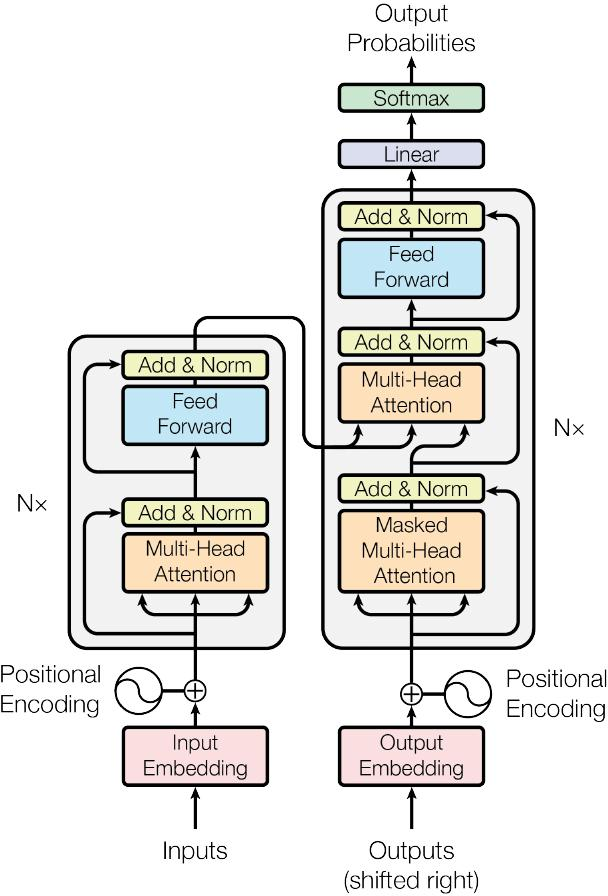

In [82]:
plt_img_base64(docs[0])

In [84]:
print(docs[1])

Attention Is All You Need

Ashish Vaswani∗ Google Brain avaswani@google.com

Noam Shazeer∗ Google Brain noam@google.com

Niki Parmar∗ Google Research nikip@google.com

Jakob Uszkoreit∗ Google Research usz@google.com

Llion Jones∗ Google Research llion@google.com

Aidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu

Łukasz Kaiser∗ Google Brain lukaszkaiser@google.com

Illia Polosukhin∗ ‡ illia.polosukhin@gmail.com

Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring signiﬁcantly less time to train.


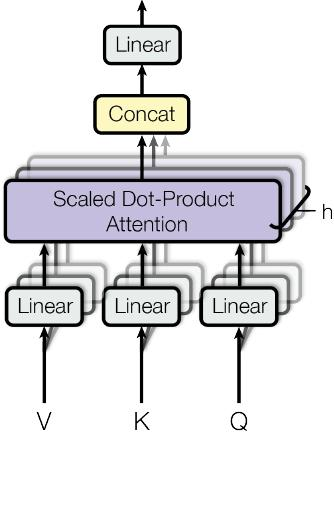

In [85]:
plt_img_base64(docs[2])